## Vanishing point detection with Hough Transform

Основная задача проектного семинара состояла в поиске точки схода на изображении, которая возникает при рарзработке систем беспилотности. Для этого был дан датасет из 803 изображений.

Датасет: Zihan Zhou, Farshid Farhat, and James Z. Wang The Pennsylvania State University: https://faculty.ist.psu.edu/zzhou/projects/vpdetection/

In [1]:
import cv2
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import linregress
%matplotlib inline
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_image(img):
    plt.figure(figsize = (5, 5))
    plt.imshow(img)

In [3]:
image = mpimg.imread('train/train/video-18-frame-757.jpg')

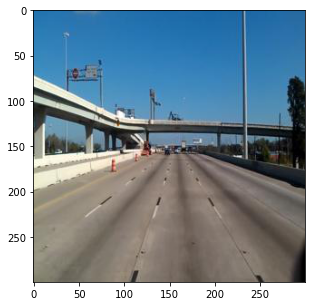

In [4]:
plt_image(image)

## Pre-processing:

### 1) Bilateral Filter

Нелинейный сглаживающий фильтр с сохранением границ и уменьшением шума для изображений заменяет интенсивность каждого пикселя средневзвешенным значением яркости соседних пикселей. Основное свойство двусторонней фильтрации заключается в том, что она не выполняет усреднение по краям, и поэтому ее еще называют фильтром, сохраняющим края.  
 
В фильтре Гаусса при фильтрации учитываются только соседние пиксели. При этом не учитывается, имеют ли пиксели почти одинаковую интенсивность или нет. Фильтр также не учитывает, является ли пиксель краевым или нет. Таким образом, он также размывает края, чего мы не хотим делать, поскольку удаляются важные детали изображения.  

Двусторонняя фильтрация также использует фильтр Гаусса в пространстве, но дополнительно учитывает еще один фильтр Гаусса, который является функцией разности пикселей. Функция Гаусса пространства гарантирует, что только близлежащие пиксели рассматриваются для размытия, а функция Гаусса разницы интенсивности гарантирует, что только те пиксели, интенсивность которых аналогична центральному пикселю, рассматриваются для размытия. Таким образом, он сохраняет края, поскольку пиксели по краям будут иметь большое изменение интенсивности.  

Важным моментом, который учитывается при двусторонней фильтрации, является то, что два пикселя находятся близко друг к другу не только в том случае, если они занимают близлежащие пространственные местоположения, но также если они имеют некоторое сходство в фотометрическом диапазоне. Эти свойства двусторонней фильтрации преодолевают недостатки других методов, таких как «Усреднение размытия», «Размытие по Гауссу» и «Медианное размытие», поскольку они позволяют сохранять края.  

Идея алгоритма:  
1) Каждый пиксель заменяется средневзвешенным значением его соседей.  
2) Каждый сосед взвешивается по компоненте пространства, которая штрафует удаленные пиксели, и по компоненте диапазона, которая штрафует пиксели с разной интенсивностью.  
3) Комбинация обоих компонентов гарантирует, что только близлежащие похожие пиксели вносят вклад в окончательный результат.  


Двусторонний фильтр управляется двумя параметрами: σs и σr.  
Если параметр диапазона σr увеличивается, двусторонний фильтр становится ближе к размытию по Гауссу. 
Увеличение пространственного параметра σs сглаживает более крупные детали.

In [5]:
# Поможет хорошо уменьшить нежелательный шум, сохраняя при этом края достаточно резкими
def bilateral_filter(img):
    return cv2.bilateralFilter(img, 5, 15, 15)

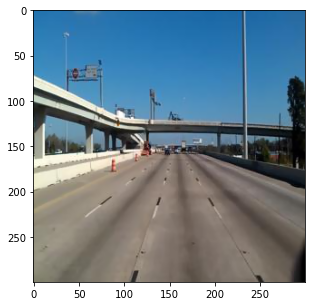

In [6]:
plt_image(bilateral_filter(image))

### 2) Contrast Limited Adaptive Histogram Equalization

Выравнивание гистограммы применимо, когда гистограмма изображения ограничена определенной областью. Оно не будет работать в местах с большими разбросами интенсивности, где гистограмма покрывает большую область, т.е. присутствуют как яркие, так и темные пиксели. В определенных случаях после выравнивания гистограммы контраст фона улучшается. Однако можно потерять большую часть информации из-за чрезмерной яркости изображения потому что его гистограмма не ограничена определенной областью.

Поэтому для решения этой проблемы используется адаптивное выравнивание гистограммы.  
В этом случае изображение разделено на небольшие блоки, называемые «плитками».  
Затем на каждом из этих блоков выравнивается гистограмма. Таким образом, на небольшой площади гистограмма будет ограничиваться небольшой областью (если нет шума). Если шум есть, он будет усилен.  
Чтобы этого избежать, применяется ограничение контраста. Если какая-либо ячейка гистограммы превышает указанный предел контрастности, эти пиксели обрезаются и равномерно распределяются по другим ячейкам перед применением выравнивания гистограммы. После выравнивания, для удаления артефактов на границах плиток применяется билинейная интерполяция.

In [7]:
def CLAHE(img): # Contrast Limited Adaptive Histogram Equalization
    cl = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (4, 4)) #создадим CLAHE объект
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Конвертируем в цвет. простр-во between RGB/BGR and YUV
    # Разложим на яркость (Y) и два цветоразностных компонента (U и V):
    Y, U, V = cv2.split(img_yuv) # делит многоканальный массив на несколько одноканальных массивов
    Y_clache = cl.apply(Y) # применим только к яркости Y
    img_yuv = cv2.merge((Y_clache, U, V)) # объединим
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) # вернем объединение в изначальное цветовое пространство

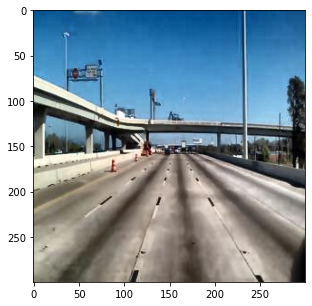

In [8]:
plt_image(CLAHE(bilateral_filter(image)))

### 3) Filter colors (yellow and white)

In [9]:
# Фильтрация изобр-я по диапазону желтого и белого
def filter_colors(img, white_val):
    white = [[white_val, white_val, white_val], [255, 255, 255]]
    yellow = [[80, 90, 90], [120, 255, 255]]    
    return color_ranges_filter(img, [white, yellow])

# Выдает HSV маску нахождения данного диапазона цвета в изобр-ии
def hsv_mask(img, color_range):
    lower = np.array(color_range[0]) # нижняя граница цвета
    upper = np.array(color_range[1]) # верхняя граница
    return cv2.inRange(img, lower, upper) # Проверяет поканально находятся ли элементы в заданных границах и выдает бин. маску
    
# Выдает маску серого
def gray_mask(img, color_range):
    return cv2.inRange(img, color_range[0][0], color_range[1][0])
    
# Выдает бин-ю маску на каждый канал со знаяяениями от 0 до 255 
def mask_ch(img, bin_mask):
    masked_image = np.zeros_like(img) # нулевая маска
    for i in range(3): # в каждый канал: синий, зеленый, красный
        masked_image[:,:,i] = bin_mask.copy() # копируем оригинал маски   
    return masked_image
    
# Фильтрует изобр-е по цветовому диапазону
def color_ranges_filter(img, color_ranges):
    result = np.zeros_like(img) # нулевая маска
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Конвертируем в цвет. простр-во BGR to Gray: 0.299R+0.587G+0.114B, средневзв значение трехк-х значений
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #Конвертируем в цвет. простр-во BGR to HSV with H range 0..180 if 8 bit image
        
    # для желтого и белого цвета по каждому порогу установить его значения B и R:
    for color_range in color_ranges:
        color_bottom = color_range[0] #B
        color_top = color_range[1] #R
        # Если все три нижних и верхних значения оказываются равны:
        if color_bottom[0] == color_bottom[1] == color_bottom[2] and color_top[0] == color_top[1] == color_top[2]:  
        # создается бин-я маска по каждому порогу   
            mask = gray_mask(gray_img, color_range) 
        else:
            mask = hsv_mask(hsv_img, color_range)
        # и накапливается в изображении для желтого и белого, как средневзв-е   
        masked_img = mask_ch(img, mask)
        result = cv2.addWeighted(masked_img, 1.0, result, 1.0, 0.0) # средневзв. сумма двух изобр-й
    return result

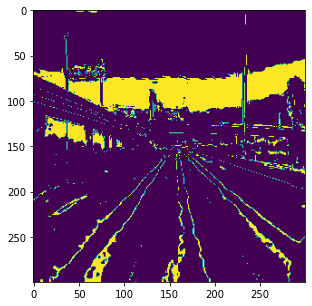

In [10]:
hsv_img = cv2.cvtColor(CLAHE(bilateral_filter(image)), cv2.COLOR_BGR2HSV)
#hsv_mask
plt_image(hsv_mask(CLAHE(bilateral_filter(image)), [[80, 90, 90], [120, 255, 255]]))

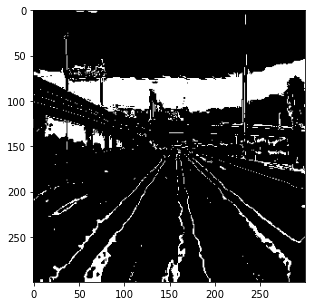

In [11]:
plt_image(mask_ch(CLAHE(bilateral_filter(image)), hsv_mask(CLAHE(bilateral_filter(image)), [[80, 90, 90], [120, 255, 255]])))

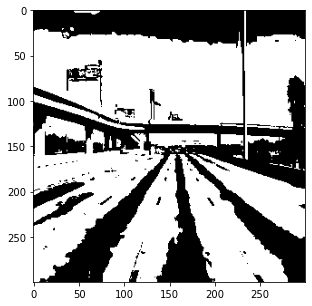

In [12]:
# filter_by_color_ranges
white = [[120, 120, 120], [255, 255, 255]]
yellow = [[80, 90, 90], [120, 255, 255]]
plt_image(color_ranges_filter(CLAHE(bilateral_filter(image)), [white, yellow]))

### 4) Canny Edge detection

#### 1. Снижение шума  
Детекция краев чувствительна к изображению с шумом. Если не удалить шум, результаты будут плохими. Итак, первый шаг - предварительная обработка изображения для устранения шума. Это можно сделать, применив фильтры Гаусса.  


#### 2. Вычисление градиента  
Края соответствуют изменению яркости пикселей. Чтобы обнаружить это, самый простой способ - применить фильтры, которые выделяют это изменение интенсивности в обоих направлениях: по горизонтали и по вертикали.
Таким образом, на этом этапе двумерный оператор первой производной, такой как оператор Собеля, применяется к сглаженному изображению как в горизонтальном, так и в вертикальном направлениях. Это поможет получить первую производную в горизонтальном направлении и вертикальном направлении, чтобы выделить области изображения с высокими первыми пространственными производными.
Края образуют выступы на изображении величины градиента. Вычисление градиента детектирует интенсивность и направление края. Направление округляется до одного из четырех возможных углов (а именно 0, 45, 90 или 135).  


#### 3. Non-Max Suppression  
После выполнения вышеуказанных шагов вычисления градиента толщина кромки неоднородна. Некоторые края толстые, а другие тонкие, а также есть нежелательные пиксели. Таким образом, чтобы решить эту проблему, используется Non-Max Suppression. На этом этапе для каждого пикселя проверяется, является ли он локальным максимумом в его окрестности в направлении градиента или нет. Проще говоря, предположим, что I (m, n) - это изображение -
тогда, если I (m, n) больше, чем два его соседа по направлению градиента theta (m, n), то оставьте I (m, n) неизменным, в противном случае установите его в 0.  


#### 4. Hysteresis Thresholding  
Этот шаг используется для определения пикселей, которые все вносят вклад в края, какие на самом деле являются краями, а какие нет. Для этого нам нужно иметь два порога T1 (High Threshold) и T2 (Low Threshold). Любые края с градиентом интенсивности больше, чем High threshold, обязательно будут краями. Любые ребра ниже minVal обязательно не будут ребрами, поэтому отбрасываем их. Те, кто находится между этими двумя порогами, классифицируются как ребра или не ребра в зависимости от их связности, то есть, если они соединены с пикселями с достаточно четкими краями, они считаются частью краев. Иначе они также выбрасываются.  


Эффект оператора Кэнни определяется тремя параметрами:   
1) шириной гауссова ядра, используемого на этапе сглаживания,  
2) верхним порогом,  
3) нижним порогом.  

Таким образом, если мы увеличиваем ширину ядра Гаусса, это снижает чувствительность детектора к шуму за счет потери некоторых из более мелких деталей изображения. Ошибка локализации обнаруженных краев также немного увеличивается с увеличением гауссовой ширины.  

Верхний порог слежения может быть установлен достаточно высоким, а нижний порог довольно низким для получения хороших результатов. Установка слишком высокого нижнего порога приведет к исчезновению шумных краев. С другой стороны, установка слишком низкого верхнего порога увеличивает количество ложных и нежелательных краевых фрагментов, появляющихся на выходе.

In [13]:
def Canny_edges(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    med = np.median(gray_img)
    sigma = 0.25
    lower = int(max(140, (1.0-sigma)*med))
    upper = int(min(255, (1.0+sigma)*med))
    return cv2.Canny(gray_img, lower, upper)

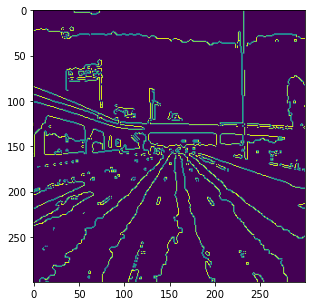

In [14]:
plt_image(Canny_edges(filter_colors(CLAHE(bilateral_filter(image)), 120)))

### Итого pre-processing:

In [15]:
def pre_process(image):
    image_blured = bilateral_filter(image)
    image_clache = CLAHE(image_blured)
    image_mask = filter_colors(image_clache, 120)
    image_edges = Canny_edges(image_mask)
    return image_edges

## Преобразование Хафа

Вероятностное преобразование Хафа не принимает во внимание все точки, вместо этого выбирает только случайное подмножество точек, и этого оказывается достаточно для обнаружения линии.  

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

In [16]:
def houghlinesP(image_edges, votes):
    linesP = cv2.HoughLinesP(image_edges, 2, np.pi / 180, votes, np.array([]), minLineLength=4, maxLineGap=424)
    hough_linesP=[]
    if linesP is not None:
        for line in linesP:
            for x1,y1,x2,y2 in line:
                hough_linesP.append([x1,y1,x2,y2])
    return hough_linesP

In [17]:
def houghlines(image_edges, votes):
    hl = cv2.HoughLines(image_edges, 2, np.pi / 180, votes)
    lines = hl #[np.where(hl[:,0,0]<283)[0]]
    hough_lines = []
    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            hough_lines.append([x1,y1,x2,y2])
    return hough_lines

In [18]:
def hough_linez(img, votes):
    # зададим диапазоны ро и тетта:
    width, height = img.shape
    thetas = np.deg2rad(np.arange(-90.0, 90.0)) # переведем из градусов в радианы
    diag = int(round(math.sqrt(width**2 + height**2))) # макс |ро|
    rhos = np.linspace(-diag, diag, diag * 2) # в диапазоне от -ро до ро
    
    num_thetas = len(thetas) # кол-во тет
    cost = np.cos(thetas) # матрица косинусов углов от -90 до 90
    sint = np.sin(thetas) # матрица синусов соотв. углов
    
    rt_matrix = np.zeros((2*diag, num_thetas), dtype=np.uint8) # Накопленная матрица тет и ро
    y_indices, x_indices = np.nonzero(img) # индекс строкки и столбца ненулевых значений в изобр-ии 

    # Голосование в накопленной матрице:
    for i in range(len(x_indices)): # каждый индекс ненулевого значения на изобр-ии:
        x = x_indices[i] # присваиваем к x и y
        y = y_indices[i]

        for theta_index in range(num_thetas): # по каждому индексу длины вектора тет
            # посчитаем ро, с добавлением диагонали
            rho = int(round(x * cost[theta_index] + y * sint[theta_index])) + diag 
            # добавляем голоса, где ро совпали при пресечении синусоид с разными сдвигами и одинаковым углом
            rt_matrix[rho, theta_index] += 1 

    # найдем координаты точек:
    def post_proc_hough_(rt_matrix, thetas, rhos, votes):
        most_voted = np.where(rt_matrix>votes) # найдем индексы выше опр-х голосов
        r = rhos[most_voted[0]]
        th = thetas[most_voted[1]]
        stacked = np.stack((r,th),1) # сформируем матрицу из ро и тет
        hough_lines = []
        for line in stacked:
            for rho, theta in [line]:
                    a = np.cos(theta)
                    b = np.sin(theta)
                    x0 = a*rho
                    y0 = b*rho
                    x1 = int(x0 + 1000*(-b))
                    y1 = int(y0 + 1000*(a))
                    x2 = int(x0 - 1000*(-b))
                    y2 = int(y0 - 1000*(a))
                    hough_lines.append([x1,y1,x2,y2]) # найдем координаты этих отрезков
        return hough_lines
    
    return post_proc_hough_(rt_matrix, thetas, rhos, votes)

In [19]:
%%time 
hough_linezz = hough_linez(Canny_edges(filter_colors(CLAHE(bilateral_filter(image)), 120)), 30)

Wall time: 4.77 s


In [20]:
%%time
lines_ = houghlines(Canny_edges(filter_colors(CLAHE(bilateral_filter(image)), 120)), 30)

Wall time: 58.1 ms


In [21]:
%%time
lin = houghlinesP(Canny_edges(filter_colors(CLAHE(bilateral_filter(image)), 120)), 30)

Wall time: 4 ms


## Post-processing:

In [22]:
# Задание угла и сдвига прямой
def line(p1, p2):
    A = p1[1] - p2[1]
    B = p2[0] - p1[0]
    C = p1[0]*p2[1] - p2[0]*p1[1]
    return A, B, -C

# Находит пересечение по двум прямым
def intersect(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return [x,y]
    else:
        return None

# Находит уникальные прямымые по пересечениям в диапазоне    
def unique_lines(lines):
    lines_its =[]
    for i, line_1 in enumerate(lines):
        for line_2 in lines[i + 1:]:
            if not line_1 == line_2:
                L1 = line(line_1[:2], line_1[2:])
                L2 = line(line_2[:2], line_2[2:])
                intersection = intersect(L1, L2)
                
                if intersection:  # если пересечения находятся в roi, то
                    if (80<intersection[0]<220) and (80<intersection[1]<220):
                        lines_its.append(line_1)
                        lines_its.append(line_2)
    # найдем уникальные прямые
    u_lines = np.unique(np.vstack(lines_its), axis=0)
    return u_lines

# Выдает координаты точки на изображении
def create_points(image, average):
    slope, y_int = average
    y1 = image.shape[0]
    y2 = int(y1 * (1/5))
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

# Выводит координаты точек по левой и правой линиям
def lin_reg_lines(image, lines):
    left_l = []
    right_l = []
    xs = []
    ys = []
    for line in lines:
        for x1, y1, x2, y2 in [line]:
            # подгоним линии по точкам и вытащим углы:
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            
            #по данным углам разделим на правые и левые линии:
            if abs(slope) > 0.12 and abs(slope) < 2.1:
                if slope < 0:
                    left_l.append([x1, y1, x2, y2])
                else:
                    right_l.append([x1, y1, x2, y2])
    
    # вытаскивает угол и сдвиг на основе лин.рег.
    def xs_ys(lines):
        xs = []
        ys = []
        for line in lines:
            for x1, y1, x2, y2 in [line]:
                xs += [x1, x2]
                ys += [y1, y2]
        
        slope, intercept, r, p, se = linregress(xs, ys)
        return slope, intercept
    # найдем обобщение для левых и правых прямых 
    left_avg = xs_ys(left_l)
    right_avg = xs_ys(right_l)

    #находим координаты этих двух линий на изображеении
    left_line = create_points(image, left_avg)
    right_line = create_points(image, right_avg)
    return np.array([left_line, right_line]) 

### Итого post-processing:

In [23]:
def post_process(image, hough_lines):
    ulines = unique_lines(hough_lines)
    averaged_lines = lin_reg_lines(image, ulines)
    L1 = line(averaged_lines[:,:2][0], averaged_lines[:,2:][0])
    L2 = line(averaged_lines[:,:2][1], averaged_lines[:,2:][1])
    L_i = intersect(L1, L2)
    return L_i 

## Найдем точку схода на всех изображениях:

## Train HoughlinesP:

Wall time: 210 ms


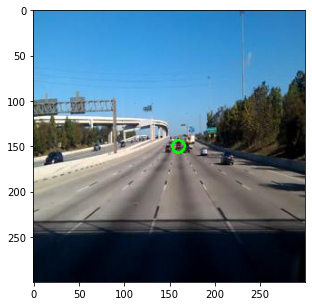

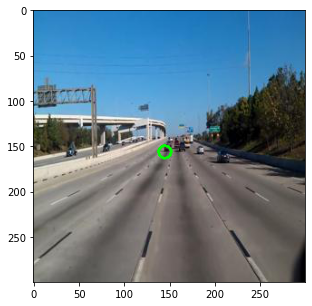

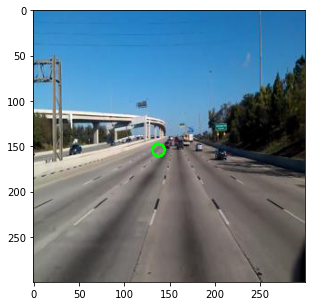

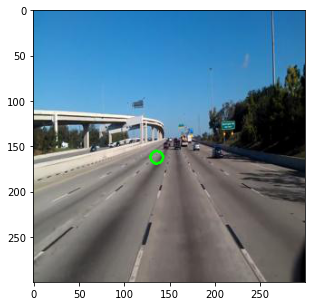

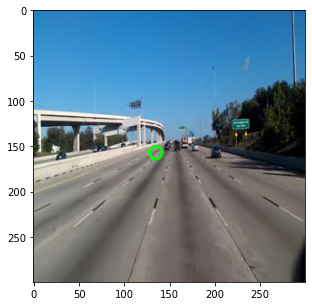

In [24]:
%%time
intrcs = []
for img in os.listdir('train/train/'):
    if img.endswith('jpg'):
        image = mpimg.imread('train/train/{}'.format(img))
        image_edges = pre_process(image)
        hough_lines = houghlinesP(image_edges, 30)
        L_i = post_process(image, hough_lines)
        #intrcs.append(["{}".format(img), L_i])
        point = cv2.circle(image, (round(L_i[0]),round(L_i[1])), radius=7, color=(0, 255, 0), thickness=2)
        plt_image(point)
        #mpimg.imsave('train/test_images4/{}'.format(img), point)

## Test Houghlines m:

Wall time: 48.2 s


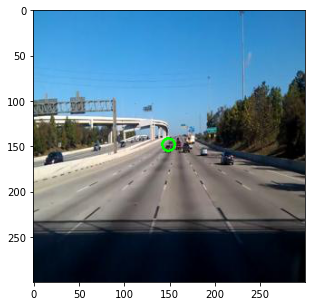

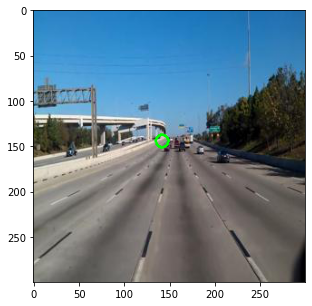

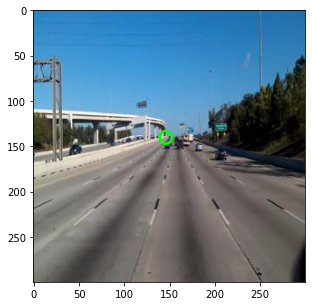

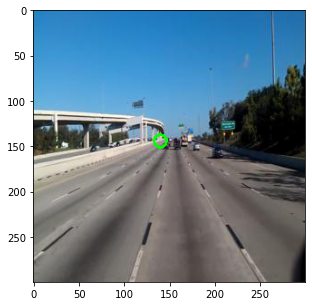

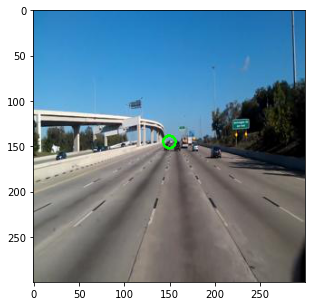

In [28]:
%%time
intrcs_Houghlines_m = []
for img in os.listdir('train/train/'):
    if img.endswith('jpg'):
        image = mpimg.imread('train/train/{}'.format(img))
        image_edges = pre_process(image)
        hough_lines = hough_linez(image_edges, 40)
        L_i = post_process(image, hough_lines)
        intrcs_Houghlines_m.append(["{}".format(img), L_i])
        point = cv2.circle(image, (round(L_i[0]),round(L_i[1])), radius=7, color=(0, 255, 0), thickness=2)
        plt_image(point)

In [79]:
with open("intrcs_Houghlines_m.json", "w") as fp:
    json.dump(intrcs_Houghlines_m, fp)

## Test Houghlines:

In [144]:
%%time
intrcs_Houghlines_cpp = []
for img in os.listdir('train/new_train/'):
    if img.endswith('jpg'):
        image = mpimg.imread('train/new_train/{}'.format(img))
        image_edges = pre_process(image)
        hough_lines = houghlines(image_edges, 40)
        L_i = post_process(image, hough_lines)
        intrcs_Houghlines_cpp.append(["{}".format(img), L_i])
        #point = cv2.circle(image, (round(L_i[0]),round(L_i[1])), radius=7, color=(0, 255, 0), thickness=2)
        #plt_image(point)

Wall time: 1min 47s


In [145]:
with open("intrcs_Houghlines_cpp.json", "w") as fp:
    json.dump(intrcs_Houghlines_cpp, fp)

## Test HoughlinesP:

In [24]:
%%time
intrcs_test_P = []
for img in os.listdir('train/new_train/'):
    if img.endswith('jpg'):
        image = mpimg.imread('train/new_train/{}'.format(img))
        image_edges = pre_process(image)
        hough_lines = houghlinesP(image_edges, 40)
        L_i = post_process(image, hough_lines)
        intrcs_test_P.append(["{}".format(img), L_i])
        #point = cv2.circle(image, (round(L_i[0]),round(L_i[1])), radius=7, color=(0, 255, 0), thickness=2)
        #plt_image(point)

Wall time: 490 ms


In [147]:
with open("my_markup_test_P.json", "w") as fp:
    json.dump(intrcs_test_P, fp)

## Вытащим их координаты (Train):

In [25]:
dict(intrcs)

{'video-18-frame-100.jpg': [163.31515957446808, 162.4468085106383],
 'video-18-frame-1000.jpg': [146.70652173913044, 154.43478260869566],
 'video-18-frame-1001.jpg': [161.66579634464753, 157.12793733681463],
 'video-18-frame-1003.jpg': [157.25977301387138, 155.33417402269862],
 'video-18-frame-1006.jpg': [163.1955990220049, 155.06112469437653],
 'video-18-frame-1008.jpg': [149.73280721533257, 149.56031567080046],
 'video-18-frame-1010.jpg': [140.91724137931035, 147.44827586206895],
 'video-18-frame-1011.jpg': [128.8799249530957, 149.8311444652908],
 'video-18-frame-1012.jpg': [140.99534450651768, 150.94972067039106],
 'video-18-frame-1013.jpg': [131.21639042357273, 145.9668508287293],
 'video-18-frame-1014.jpg': [155.78026905829597, 162.2421524663677],
 'video-18-frame-1016.jpg': [128.39659367396592, 158.68613138686132],
 'video-18-frame-1017.jpg': [155.72417982989063, 167.6063183475091],
 'video-18-frame-1019.jpg': [150.9296875, 166.875],
 'video-18-frame-102.jpg': [173.42379679144386

In [27]:
with open("my_markup.json", "r") as fp:
    my_markup = dict(json.load(fp))

### Угловая метрика:

In [25]:
import argparse
import random
from math import degrees
from numpy.core.fromnumeric import shape

In [26]:
def read_from_json(path):
    answers = dict()

    with open(path, 'r') as json_file:
        answers = json.load(json_file)

    return answers

def get_shapes(path):
    names = os.listdir(path)
    return {name: cv2.imread(os.path.join(path, name)).shape[0:2] for name in names if not name.endswith('.csv')}


def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def calculate_angle(ans, gt, shape):
    n,m = shape
    
    O = np.array((n/2, m/2, ((n/2)**2 + (m/2)**2)**0.5))
    A = np.array((ans[0], ans[1], 0))
    GT = np.array((gt[0], gt[1], 0))

    return angle_between(A - O, GT - O)


def calc_metrics(path_to_answers, path_to_gt, path_to_imgs):
    answers = dict(read_from_json(path_to_answers))
    gt = read_from_json(path_to_gt)
    shapes = get_shapes(path_to_imgs)

    #if set(answers.keys()) != set(gt.keys()) or set(answers.keys()) != set(shapes.keys()):
    #    raise ValueError('Names of files in gt, answers or in folder does not match!\n')

    angles = []
    for name in gt:
        angle = calculate_angle(answers[name], gt[name], shapes[name])
        angles.append(angle)

    angles = np.array(angles)

    return np.mean(angles), np.median(angles)

In [27]:
path_to_gt=r'C:\Users\Design\Downloads\new_train\markup.json'
path_to_imgs=r'C:\Users\Design\Downloads\new_train\new'

In [29]:
path_to_answers1 =r'C:\Users\Design\Downloads\new_train\my_markup_test_P.json'
#path_to_answers2 =r'C:\Users\Design\Downloads\new_train\intrcs_Houghlines_cpp.json'
#path_to_answers3 =r'C:\Users\Design\Downloads\new_train\intrcs_Houghlines_m.json'

mean1, median1= calc_metrics(path_to_answers1, path_to_gt, path_to_imgs)
#mean2, median2 = calc_metrics(path_to_answers2, path_to_gt, path_to_imgs)
#mean3, median3 = calc_metrics(path_to_answers3, path_to_gt, path_to_imgs)
print(f"Mean: {mean1}, median: {median1}")
#print(f"Mean: {mean2}, median: {median2}")
#print(f"Mean: {mean3}, median: {median3}")

Mean: 5.008517058714373, median: 4.540182953230886
